# Grocery Store Recomendation System 
###With Neural Network 
<hr>
To suppy better customer experience in our grocery store, We are trying to suggest "recommendation system". From our Recommend system, Our customers can have better satisfaction for the shopping. We aim to have potential customer by providing cutomer-oriented services. To solve this problem, We compare the recommendation system implemented by 3 different algorithms.

In this notebook, Recommendation system based on item is presented with tensorflow. 

# 1. Import Libraries and Data Load


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
!apt-get update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubun

Define base and file path to bring datafile to note book

In [ ]:
try:
  # Only it runs in google collab
  # from google.colab import drive # if this package don't exist we aren't con google colab
  import os
  # Install spark and its requirements
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  !wget -nc -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
  !tar xf spark-3.2.0-bin-hadoop3.2.tgz
  !pip install -q pyspark
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
  drive.mount('/content/drive')
  base_path = '/content/drive/MyDrive/BigData/' # Google Drive
except:
  # It runs in local 
  base_path = ''


Mounted at /content/drive


In [ ]:
file_products = base_path + 'data/ARTICLES.csv'
file_families = base_path + 'data/AECOC.csv'
file_sells = base_path + 'data/s20.csv'
file_products

'/content/drive/MyDrive/BigData/data/ARTICLES.csv'

Initialize the spark session
Import Libararies for Tensorflow, Keras, 

In [ ]:
# Import Spark libs
from pyspark.sql import SparkSession
from IPython.display import display, HTML
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import col

# Initiate SparkSession
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
from tensorflow.keras.utils import plot_model
%matplotlib inline

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 2. Preprocessing the data

In this chapter, 'Invoice_Id', 'product_id','units' are extracted from the file "2020.T105.csv".
In this project, we just use 'units' feature of 'product_id'feacuture per invoice_id to expect the recommendation.
To adjust embedding layer in the neural network model, the range of value of 'invoice_id' and 'product_id' are in the length of unique 'invoice_id' and 'product_id'.

So, by the **number of unique invoice_id**(127422 ) and **number  of unique product_id** (2840), each value in the 'invoice_id' and 'product_id' columns are in the range of [0, 127422] and [0, 2840] each.



###2-1 : set the values in right form

In [ ]:
#sales data from 'data/2020.T105.csv'
sells_2020 = pd.read_csv(file_sells,sep=';',encoding='ISO-8859-1',\
                    names=['invoice_id','product_id','units','amount','checkout','date','hour'])
sells_2020.head()

,invoice_id,product_id,units,amount,checkout,date,hour
0,2027-T0105C01-100089,5379,1000000,171,1,19282,64396
1,2027-T0105C01-100089,5379,1000000,160,1,19282,64396
2,2027-T0105C01-100089,3482,1000000,63,1,19282,64396
3,2027-T0105C01-100089,3059,1000000,45,1,19282,64396
4,2027-T0105C01-100089,3059,1000000,45,1,19282,64396


In [ ]:
product_df = pd.read_csv(file_products,sep=';',encoding='ISO-8859-1', skiprows=1,\
                    names=['product_id','product_desc','x1','x2','x3','family_id'])     
product_df= product_df.drop(['x1','x2','x3'], axis = 1)
product_df

,product_id,product_desc,family_id
0,10000,LIMPIACRISTALES CON,03*01*06
1,10001,LIMPIACRISTALES RECA,03*01*06
2,10002,LIMPIACRISTALES BONA,03*01*06
3,10003,LIMPIACRISTALES BONA,03*01*06
4,10004,FREGASUELOS CAG 1 L,03*01*06
...,...,...,...
72195,9810,RECAR. EQUIV. REDUCI,00*00*00
72196,9820,I.V.A. NORMAL,00*00*00
72197,9830,RECAR. EQUV. NORMAL,00*00*00
72198,9840,COMISION EXTRANGEROS,00*00*00


In [ ]:
#set the units to real number
sells_2020['units']  = 1;
sells_2020

,invoice_id,product_id,units,amount,checkout,date,hour
0,2027-T0105C01-100089,5379,1,171,1,19282,64396
1,2027-T0105C01-100089,5379,1,160,1,19282,64396
2,2027-T0105C01-100089,3482,1,63,1,19282,64396
3,2027-T0105C01-100089,3059,1,45,1,19282,64396
4,2027-T0105C01-100089,3059,1,45,1,19282,64396
...,...,...,...,...,...,...,...
1263371,2027-T0105C01-99989,5235,1,408,1,19282,52625
1263372,2027-T0105C01-99989,6899,1,175,1,19282,52625
1263373,2027-T0105C01-99989,5856,1,117,1,19282,52625
1263374,2027-T0105C01-99989,5990,1,227,1,19282,52625


Define a new dataframe from row dataframe with compulsary columns.
Also, summerize the units by 'invoice_id' and 'product_id'

In [ ]:
sells_subset = sells_2020[['invoice_id','product_id','units']]
processed = sells_subset.groupby(by=['invoice_id','product_id'],as_index=False).sum()
processed

,invoice_id,product_id,units
0,2027-T0105C01-1,7673,1
1,2027-T0105C01-1,8338,1
2,2027-T0105C01-10,4496,1
3,2027-T0105C01-10,5479,1
4,2027-T0105C01-10,5797,1
...,...,...,...
1037382,2027-T0105C01-99999,3585,1
1037383,2027-T0105C01-99999,5304,2
1037384,2027-T0105C01-99999,5894,1
1037385,2027-T0105C01-99999,8371,1


###2-2 : Check the 'invoice_id' in range
'invoice_id' column is arraged in processed dataframe and the last value of 'invoice id 'is 99999. Therefore, all the values in 'invoice_id column is in the proper arrange for embedding [0, number_of_unique_id(127422)].

In [ ]:

processed['invoice_id'] = processed['invoice_id'].str.replace( '2027-T0105C01-','')
processed=processed.astype({"invoice_id":'int64'})
processed

,invoice_id,product_id,units
0,1,7673,1
1,1,8338,1
2,10,4496,1
3,10,5479,1
4,10,5797,1
...,...,...,...
1037382,99999,3585,1
1037383,99999,5304,2
1037384,99999,5894,1
1037385,99999,8371,1


In [ ]:
processed = processed.sort_values('invoice_id')
processed

,invoice_id,product_id,units
0,1,7673,1
1,1,8338,1
287427,2,3483,1
287428,2,4478,1
287429,2,5304,1
...,...,...,...
234864,127421,21965,1
234865,127421,24729,1
234868,127422,90484,1
234866,127422,9771,2


### 2-3 : suit the 'product_id' in range 
To check that value of 'product_id' are in the range, sort the product_id.
In the product dataframe which is sorted by 'product_id' from processed dataframe, final **value of 'product_id' is out of range** [0, number_of_unique_family (2840)]

To suit the 'product_id' to proper range, set the number from 0 and increase the number of pid by 'product_id'. **'pid'** column of product dataframe will substitue the 'product_id' column for the traning model.

In [ ]:
product = processed.groupby(["product_id"],as_index=False).count()
product = product[['product_id']]
product['pid'] = np.arange(len(product))
product

,product_id,pid
0,200,0
1,202,1
2,206,2
3,207,3
4,208,4
...,...,...
2835,91534,2835
2836,91541,2836
2837,91549,2837
2838,91554,2838


#3.Set the traning set and test set
df_ready dataframe will be distributed for training and test dataset with **"train_test_split"** API. In this project, we will use 80% of dataset as a training dataset and 20% of dataset as a test dataset. 


In [ ]:
df_ready = pd.merge(processed,product, left_on = 'product_id', right_on='product_id', how='outer')
# df_ready=df_ready.astype({"invoice_id":'int64'})
df_ready= df_ready.sort_values('invoice_id')
df_ready

,invoice_id,product_id,units,pid
0,1,7673,1,874
1289,1,8338,1,1084
2494,2,4478,1,430
4270,2,5304,1,470
1953,2,3483,1,374
...,...,...,...,...
135585,127421,20892,1,1509
986471,127421,6300,1,658
250770,127422,9771,2,1219
664753,127422,87147,1,1994


In [ ]:
training,test = train_test_split(df_ready, test_size=0.2, random_state=777)
print(training.shape, test.shape)
training.head(1000)

(829909, 4) (207478, 4)


,invoice_id,product_id,units,pid
686806,49813,24038,1,1725
1016710,96471,9117,1,1211
285495,96469,218,1,11
837392,112984,87962,1,2151
149277,117785,7895,1,966
...,...,...,...,...
541964,75542,7764,1,905
95409,57265,8055,1,971
453919,36876,5824,1,528
725647,32123,8507,1,1167


In [ ]:
#Define the number of unique invoice id
#Define the number of unique product_id
number_of_unique_invoice = len(df_ready.invoice_id.unique())

number_of_unique_family = len(df_ready.pid.unique())

print(number_of_unique_invoice,number_of_unique_family)

127422 2840


#4. Build the model
This model is built with keras which is a neural network library based on python. It is composed of a few layers. The plot of the model is presented down blow.

The layers used in the this models are following : 
1. input layer : get the inputs. It has two input layer for **'invoice ID'** and **Pid** and one output layout. 

2. Embedding layer : give weights for variables to be learned in the model.  

3. Flatten layer : reduce 1 dimension of the vector. 

4. Concatenate layer : merge the branchs of **'invoice ID'** and **Pid**

5. Dense layer : connect input and output layer fully.

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#keep2

invoice_input = Input(shape=(1,), name='invoice_input_layer')
family_input = Input(shape=(1,), name='family_input_layer')

invoice_embedding_layer = Embedding(number_of_unique_invoice+1, 8,name ='invoice_embedding_layer')
family_embedding_layer = Embedding(number_of_unique_family+1, 8, name='family_embedding_layer')

invoice_vector_layer = Flatten(name='invoice_vector_layer')
family_vector_layer = Flatten(name='family_vector_layer')


concate_layer = Concatenate()

dense_layer1 = Dense(128, activation='relu')
dense_layer2 = Dense(32, activation='relu')

result_layer = Dense(1)

In [ ]:
#keep2

invoice_embedding = invoice_embedding_layer(invoice_input)
family_embedding = family_embedding_layer(family_input)

invoice_vector = invoice_vector_layer(invoice_embedding)
family_vector = family_vector_layer(family_embedding)

concat = concate_layer([invoice_vector,family_vector])
dense1 = dense_layer1(concat)
dense2 = dense_layer2(dense1)

result = result_layer(dense2)

model = Model(inputs=[invoice_input, family_input], outputs = result)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 invoice_input_layer (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 family_input_layer (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 invoice_embedding_layer (Embed  (None, 1, 8)        1019384     ['invoice_input_layer[0][0]']    
 ding)                                                                                      

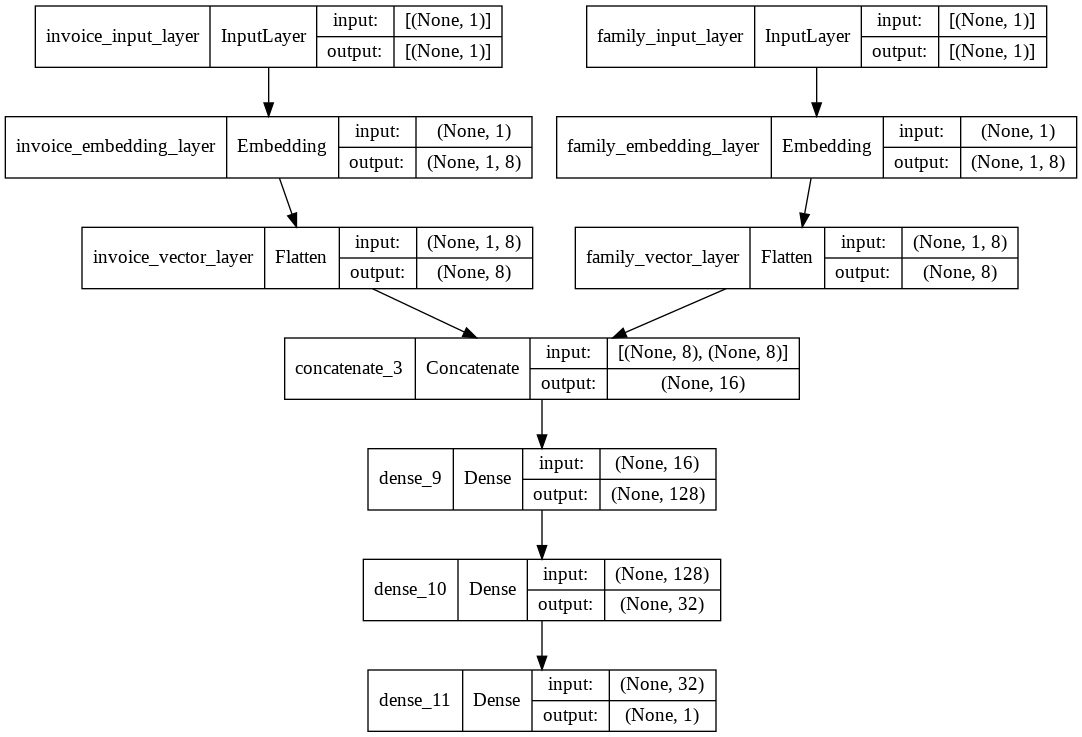

In [ ]:
#keep
plot_model(model, to_file='./dense_predict_model.png', show_shapes=True, show_layer_names=True)

##4. Trainining the Data 
Compile the model. To train the model, use the input as **[training.invoice_id, training.pid]**. When compiling model, we use 'mse' as metric to evaluate the model performance.

In [ ]:
from keras import backend as K
def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1)) 
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) 

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_negative = K.sum(y_target_yn)

    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    print("y_target_yn",y_target_yn,"y_pred_yn",y_pred_yn,"count_true_positive",count_true_positive,"count_true_positive_false_negative",count_true_positive_false_negative,
                "recall",recall)
    return recall

def precision(y_target, y_pred):

    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) 
    y_target_yn = K.round(K.clip(y_target, 0, 1))

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    count_true_positive_false_positive = K.sum(y_pred_yn)

    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())
    print("y_target_yn",y_target_yn,"y_pred_yn",y_pred_yn,"count_true_positive",count_true_positive,"count_true_positive_false_positive",count_true_positive_false_positive,
                "precision",precision)
    return precision
def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    return _f1score



In [ ]:

model.compile(loss='mse',optimizer='sgd',metrics=['mse'])

In [ ]:
history = model.fit([training.invoice_id, training.pid], training.units, epochs=5,  batch_size = 32,verbose=1)

Epoch 1/5
25935/25935 [==============================] - 45s 2ms/step - loss: 0.2925 - mse: 0.2925
Epoch 2/5
25935/25935 [==============================] - 45s 2ms/step - loss: 0.2805 - mse: 0.2805
Epoch 3/5
25935/25935 [==============================] - 45s 2ms/step - loss: 0.2793 - mse: 0.2793
Epoch 4/5
25935/25935 [==============================] - 44s 2ms/step - loss: 0.2788 - mse: 0.2788
Epoch 5/5
25935/25935 [==============================] - 45s 2ms/step - loss: 0.2785 - mse: 0.2785


Text(0, 0.5, 'training error')

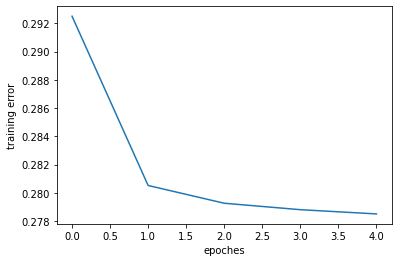

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoches')
plt.ylabel('training error')

##5.Test model

In this notebook, we use prediction model. To evaluate performance of the predicion model, MSE, RMSE, MAE, MAPE are used. Therefore, **MSE** is use to evalutate the model used in this notebook. 

**MSE** - Mean Squared Error 

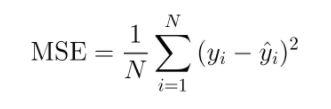

##5.1 Test model with test dataset
Model can be evaluted with test dataset. In this case, We use mse for evaluation metrics 
**MSE : 0.2804**

In [ ]:
model.evaluate([test.invoice_id, test.pid], test.units)

6484/6484 [==============================] - 10s 2ms/step - loss: 0.2804 - mse: 0.2804


[0.2803522050380707, 0.2803522050380707]

Predictions are the expected unit per each pid. 

In [ ]:

predictions = model.predict ([test.invoice_id, test.pid])
predictions


array([[1.3179587],
       [1.3535395],
       [1.073415 ],
       ...,
       [1.13726  ],
       [1.4610863],
       [1.109274 ]], dtype=float32)

In [ ]:
print( len(list(predictions)), len(test.pid))

207478

In the result_df dataframe, we can compare the real units and predictions. 

In [ ]:
result_df =pd.DataFrame()
result_df['test_units'] = test.units
result_df['predictions'] = predictions
result_df

,test_units,predictions
592429,1,1.317959
848598,2,1.353539
700331,1,1.073415
612349,1,1.067494
458184,1,1.125359
...,...,...
216584,1,1.214687
748362,1,1.274643
755685,2,1.137260
250863,2,1.461086




---

##5.2 Evaluate model :  Precision / MSE, RMSE
To evaluate the model, I have to tried to get precision using sklearn.model_selection library and **cross validation with K_fold.** 
However, outpus is not the discrete value. It means that.this model is not a classification model. So that It was not able to evaluate the model with precision. 

In [ ]:
from sklearn.model_selection import cross_val_score , cross_validate, KFold
#cross validation 교차검증 설정
k_fold = KFold(n_splits=20, random_state=1, shuffle=True)

In [ ]:
#initiate the <evaluation metrics>
from sklearn.metrics import precision_score ,make_scorer,accuracy_score 
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score)
    
}

In [ ]:
#As you can see on the Value Error message, Classification metrics (Precision) can't handle sequential value (example : 1.23442)
precision_score(test.units,predictions)

ValueError: ignored

Instead of using Percision, **RSME : 0.5294829105987167**

In [ ]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

print("RSME : ", RMSE(test.units,predictions))

RSME :  0.5294829105987167


##5.Recommendation
The result of the model present the expected units of the each 'pid' of input. So that it was not possible to recommend the items per each customer(invoice_id).Also, recommended item is only presented  among the input 'pid'. 

In [ ]:
#show the processed data for prediction
df_ready

,invoice_id,product_id,units,pid
0,1,7673,1,874
1289,1,8338,1,1084
2494,2,4478,1,430
4270,2,5304,1,470
1953,2,3483,1,374
...,...,...,...,...
135585,127421,20892,1,1509
986471,127421,6300,1,658
250770,127422,9771,2,1219
664753,127422,87147,1,1994


In [ ]:
#show the product data for shoing prediction information
product_df

,product_id,product_desc,family_id
0,10000,LIMPIACRISTALES CON,03*01*06
1,10001,LIMPIACRISTALES RECA,03*01*06
2,10002,LIMPIACRISTALES BONA,03*01*06
3,10003,LIMPIACRISTALES BONA,03*01*06
4,10004,FREGASUELOS CAG 1 L,03*01*06
...,...,...,...
72195,9810,RECAR. EQUIV. REDUCI,00*00*00
72196,9820,I.V.A. NORMAL,00*00*00
72197,9830,RECAR. EQUV. NORMAL,00*00*00
72198,9840,COMISION EXTRANGEROS,00*00*00


In [ ]:
product_data = np.array(list(set(df_ready.pid)))
product_data

array([   0,    1,    2, ..., 2837, 2838, 2839])

In [ ]:
user = np.array([1 for i in range(len(product_data))])
user[:5]
# len(user)

array([4, 4, 4, 4, 4])

In [ ]:
#get a prediction of df_ready from the model

total_predictions = model.predict([user, product_data])
print("length of predictions",len(total_predictions),"list of predictions", total_predictions)

length of predictions 2840 list of predictions [[1.4880053]
 [1.5963328]
 [1.3155982]
 ...
 [1.2535428]
 [1.1898993]
 [1.1128936]]


In [ ]:
predictions_list = np.array([a[0] for a in total_predictions])
recommended_idx = (-predictions_list).argsort()[:5]

print(recommended_idx, predictions_list[recommended_idx])

[ 426 2611 1468  101 2708] [2.6231813 2.4763322 2.2640612 2.2546034 2.1552968]


In [ ]:
#top 5 recommended items
recommended_df = df_ready[df_ready['pid'].isin(recommended_idx)]

,invoice_id,product_id,units,pid
228463,35,4474,1,426
228464,100,4474,1,426
228465,330,4474,5,426
228466,373,4474,1,426
228467,423,4474,1,426
...,...,...,...,...
229099,126955,4474,1,426
229100,127074,4474,1,426
878304,127085,90897,1,2611
878305,127254,90897,2,2611


In [ ]:
recommended_product_list = list(set(recommended_df.product_id))
recommended_product_list

[1504, 20762, 90897, 4474, 91195]

In [ ]:
# recommended_df = pd.merge(recommended_df,product_df, left_on = 'product_id', right_on='product_id', how='inner')

recommended_df = product_df[product_df['product_id'].isin(recommended_product_list)]

In [ ]:
recommended_df

,product_id,product_desc,family_id
1620,20762,BEBIDA ENERGETICA RE,01*04*02
13015,90897,CERVEZA ESTRELLA GAL,01*04*04
13313,91195,CERVEZA CORTES BOTEL,01*04*04
65033,1504,VIENTRE DE VACUNO,02*01*01
67443,4474,HIGADO DE CERDO,02*01*02




---



##6.Conclusion


This algorythm is availble to recommend the item based on the history of sales. However, it is not able to considering sequence of sales. Also, the recommendation result doesn't suit for our goal of recommendation. 


We aim that presenting personalized recommendation among whole product in the store. However, It was not complished in this model. Even though the result of the model was not remarkable, the experience of implementing recommendation system using Neural Network is impressive. 

From this result, We could figure out that building neural network model is most important part of the Neural Network Model. Also, we have searched about other solution. Using RNN (Recurrent Nerual Network), We will be able to expect better performance. 
